# Plot Variable $n$-Satellite Simulations

In [1]:
import Interval_Matrix_Algebra_Calculator_v0 as imac
import portion as P
import dionysus as d
import numpy as np 
from itertools import permutations

import matplotlib.pyplot as plt

## Generate Simulations

In [2]:
from os_utilities import *
from orb_builder import *

orb_filenames = [] # used to keep track of what files to feed into soap

prefix = "" # earth / moon / mars

# n_list = [20] # number of satellites to sample from starlink
# n_list = [20, 40, 60, 80, 100] # number of satellites to sample from starlink
# n_list = [20, 30] # number of satellites to sample from starlink
# n = len(n_list)
n = 10

sample_size = 20

folder = "/home/zeno/Documents/repositories/nasa-2022/tvg-dataset/starlink"
folder = "/home/zeno/Documents/repositories/nasa-2022/satParsing/outputs/sim-2023-01-26"
folder = "/home/zeno/Documents/repositories/nasa-2022/satParsing/outputs/starlink-10-sat-single"

## Parse Contact Analysis Reports

In [3]:
def unit_matrix(m): # , start_time, end_time
    matrix = []
    for i in range(m):
        row = []
        for j in range(m):
            row.append(P.closed(-P.inf, P.inf))
        matrix.append(row)
    return matrix

def identity_matrix(m):
    matrix = []
    for i in range(m):
        row = []
        for j in range(m):
            if i == j:
                row.append(P.closed(-P.inf, P.inf))
            else:
                row.append(P.empty())
        matrix.append(row)
    return matrix
        

A_list = []
B_list = []
m_list = []

folder_n = folder + "/starlink-{}-sat-multiple".format(n)
folder_n = folder + "/starlink-{}-sat-single".format(n)
folder_n = folder
for i in range(sample_size):
        
    filename = folder_n + "/starlink_{}_sats_{} Contact Analysis.csv".format(n, i)
    A = imac.soapConverter(filename)
    A_list.append(A)
    # filename = folder + "/starlink_b Contact Analysis.csv"
    # B = imac.soapConverter(filename)

    m = len(A)
    m_list.append(m)

    B = unit_matrix(m)
    B_list.append(B)

    print("{} : len(A_n) = {}, len(B_n) = {}, n = {}".format(i, m, len(B), n))

0 : len(A_n) = 10, len(B_n) = 10, n = 10
1 : len(A_n) = 10, len(B_n) = 10, n = 10
2 : len(A_n) = 10, len(B_n) = 10, n = 10
3 : len(A_n) = 9, len(B_n) = 9, n = 10
4 : len(A_n) = 10, len(B_n) = 10, n = 10
5 : len(A_n) = 10, len(B_n) = 10, n = 10
6 : len(A_n) = 10, len(B_n) = 10, n = 10
7 : len(A_n) = 10, len(B_n) = 10, n = 10
8 : len(A_n) = 10, len(B_n) = 10, n = 10
9 : len(A_n) = 10, len(B_n) = 10, n = 10
10 : len(A_n) = 9, len(B_n) = 9, n = 10
11 : len(A_n) = 10, len(B_n) = 10, n = 10
12 : len(A_n) = 10, len(B_n) = 10, n = 10
13 : len(A_n) = 10, len(B_n) = 10, n = 10
14 : len(A_n) = 10, len(B_n) = 10, n = 10
15 : len(A_n) = 9, len(B_n) = 9, n = 10
16 : len(A_n) = 10, len(B_n) = 10, n = 10
17 : len(A_n) = 10, len(B_n) = 10, n = 10
18 : len(A_n) = 10, len(B_n) = 10, n = 10
19 : len(A_n) = 10, len(B_n) = 10, n = 10


## Calculate Distances

In [4]:
from distances_tvg import *

start_time = 0
end_time = 86400

## Distance on $k$-Walk TVG's

In [5]:
walk_length = 10
q = 2

x = list(range(walk_length))

A_walks = []

for i in range(sample_size):
    print("/starlink_{}_sats_{}".format(n, i))
    m = m_list[i]
    # A_walks.append([unit_matrix(m)]) # A_walks[i] = [A^0, A^1, ... A^k]
    A_walks.append([identity_matrix(m)]) # A_walks[i] = [A^0, A^1, ... A^k]
    
    A = A_list[i]
    B = B_list[i]
    m = m_list[i]
    
    # calculate powers up to walk_length
    for k in range(1, walk_length):  
        print("\tCalculating {}-Walks for {}-th {}-Sat system".format(k, i, n))
        if k == 1:
            A_k = A
        else:
            A_k = imac.interval_matrix_mult(A_walks[i][-1], A)
        A_walks[i].append(A_k)

/starlink_10_sats_0
	Calculating 1-Walks for 0-th 10-Sat system
	Calculating 2-Walks for 0-th 10-Sat system
	Calculating 3-Walks for 0-th 10-Sat system
	Calculating 4-Walks for 0-th 10-Sat system
	Calculating 5-Walks for 0-th 10-Sat system
	Calculating 6-Walks for 0-th 10-Sat system
	Calculating 7-Walks for 0-th 10-Sat system
	Calculating 8-Walks for 0-th 10-Sat system
	Calculating 9-Walks for 0-th 10-Sat system
/starlink_10_sats_1
	Calculating 1-Walks for 1-th 10-Sat system
	Calculating 2-Walks for 1-th 10-Sat system
	Calculating 3-Walks for 1-th 10-Sat system
	Calculating 4-Walks for 1-th 10-Sat system
	Calculating 5-Walks for 1-th 10-Sat system
	Calculating 6-Walks for 1-th 10-Sat system
	Calculating 7-Walks for 1-th 10-Sat system
	Calculating 8-Walks for 1-th 10-Sat system
	Calculating 9-Walks for 1-th 10-Sat system
/starlink_10_sats_2
	Calculating 1-Walks for 2-th 10-Sat system
	Calculating 2-Walks for 2-th 10-Sat system
	Calculating 3-Walks for 2-th 10-Sat system
	Calculating 4-W

	Calculating 5-Walks for 19-th 10-Sat system
	Calculating 6-Walks for 19-th 10-Sat system
	Calculating 7-Walks for 19-th 10-Sat system
	Calculating 8-Walks for 19-th 10-Sat system
	Calculating 9-Walks for 19-th 10-Sat system


## Calculate Lifetime Matrices

In [6]:
y_lifetime_list = []
for l in range(sample_size):
    A = A_list[l]
    m = m_list[l]
    L = tvg_lifetime_matrix(A_walks[l], start_time, end_time, walk_length)
    
    y_list = []
    for i in range(0, m):
        for j in range(i + 1, m):
            y = []
            for k in range(0, walk_length):
                interval_sum = L[(k, i, j)]
                y.append(interval_sum)
            y_list.append(y)
            # ax.plot(x, y, label="{},{}".format(i, j))
        # interval_sum = L[(k, i, j)]
        # y.append(interval_sum)
        # print("L(mu^{})({}, {}) = {}".format(k, i, j, interval_sum))
    # print(len(y_list))            
    y_list_average = []
    for k in range(0, walk_length):
        average_sum = 0
        for y in y_list:
            average_sum += y[k]
        average = average_sum / len(y_list)
        y_list_average.append(average)
        
    y_lifetime_list.append(y_list_average)

## Plot Distances

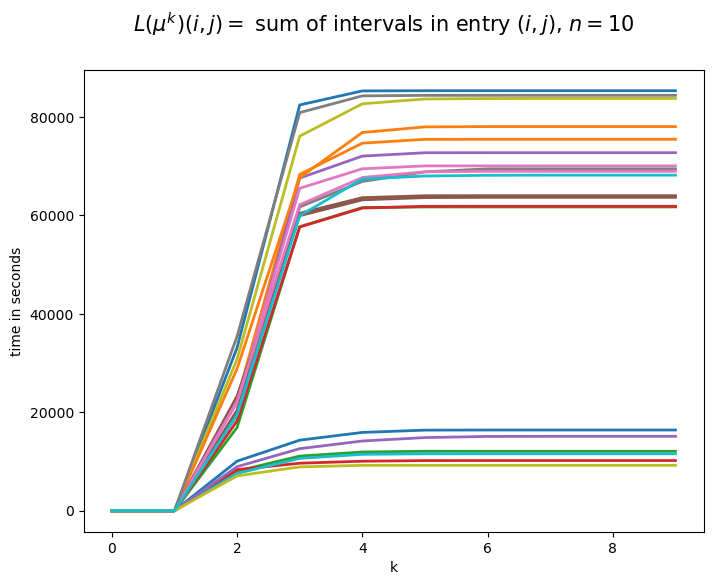

In [7]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_xlabel('k')
ax.set_ylabel('time in seconds')
fig.suptitle('$L(\mu^k)(i, j) = $ sum of intervals in entry $(i, j)$, $n = {}$'.format(n), fontsize=15)
for i in range(sample_size):
    ax.plot(x, y_lifetime_list[i], linewidth=2)
plt.show()

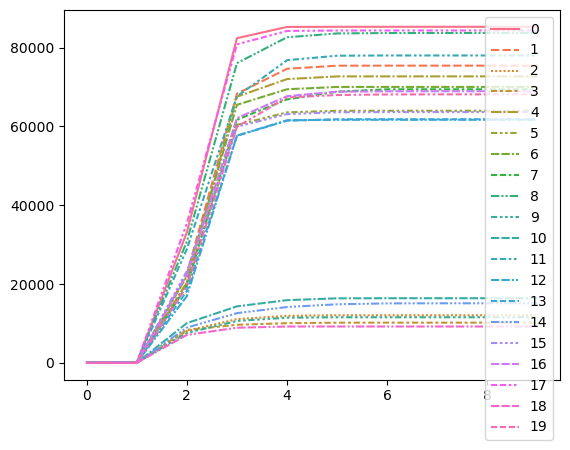

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

fig, ax = plt.subplots()

sns.lineplot(data = y_lifetime_list)

plt.show()